### Deliverable 3: Optimize the deep learning model

In [82]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

#  Import and read the charity_data.csv.
from pathlib import Path

file = Path("charity_data.csv")
application_df = pd.read_csv(file)
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [83]:
# Drop more non-beneficial ID columns, 'EIN', 'ORGANIZATION','AFFILIATION',and 'NAME'.
application_df = application_df.drop(columns=["EIN","ORGANIZATION","NAME"])
print(application_df.shape)
application_df.head()

(34299, 9)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,1,100000-499999,N,142590,1


In [84]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [85]:
# # Look at AFFILIATION	 value counts for binning
aff_counts = application_df['AFFILIATION'].value_counts()
aff_counts

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

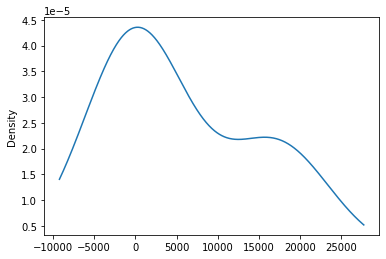

In [86]:
# Visualize the value counts of AFFILIATION	
aff_counts.plot.density()
# aff_counts = application_df['AFFILIATION'].value_counts().plot.kde()

In [87]:
# # Decreasing and replacing values if counts are less than 2?
replace_affiliation = list(aff_counts[aff_counts < 100].index)
# Replace in dataframe
for aff in replace_affiliation:
    application_df.AFFILIATION = application_df.AFFILIATION.replace(aff,"others")
    
# Check to make sure binning was successful
application_df.AFFILIATION.value_counts()

Independent         18480
CompanySponsored    15705
others                114
Name: AFFILIATION, dtype: int64

In [88]:
# Look at APPLICATION_TYPE value counts for binning
app_counts = application_df['APPLICATION_TYPE'].value_counts()

In [ ]:
# Visualize the value counts of APPLICATION_TYPE
# app_counts.plot.density()
# app_counts = application_df['APPLICATION_TYPE'].value_counts().plot.kde()
# app_counts

In [90]:
# Decreasing and replacing values if counts are less than 600?
replace_application = list(app_counts[app_counts < 1200].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
Other     4504
T4        1542
T6        1216
Name: APPLICATION_TYPE, dtype: int64

In [91]:
# Look at CLASSIFICATION value counts for binning
class_counts = application_df['CLASSIFICATION'].value_counts()


In [ ]:
# Visualize the value counts of CLASSIFICATION
# class_counts.plot.density()

In [92]:
# Determine which values to replace if counts are less than 1900?
replace_class = list(class_counts[class_counts < 1900].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     4144
C3000     1918
Name: CLASSIFICATION, dtype: int64

In [93]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Check number of unique value in each column
application_df[application_cat].nunique()


APPLICATION_TYPE          4
AFFILIATION               3
CLASSIFICATION            5
USE_CASE                  5
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [94]:
# Create a OneHotEncoder instance
new_enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
new_encode_df = pd.DataFrame(new_enc.fit_transform(application_df[application_cat]))


# Add the encoded variable names to the dataframe
new_encode_df.columns = new_enc.get_feature_names(application_cat)
new_encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_others,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [98]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(new_encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_others,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [153]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=["IS_SUCCESSFUL"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


In [154]:
# Create a StandardScaler instances
new_scaler = StandardScaler()

# Fit the StandardScaler
X_scaler_new = new_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler_new.transform(X_train)
X_test_scaled = X_scaler_new.transform(X_test)

### Compile, Train and Evaluate the Model

In [155]:
# Increasing the number the number of input features and hidden nodes for each layer of
# - deep neural model

number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 42
hidden_nodes_layer2 = 20

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_new.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 42)                1302      
_________________________________________________________________
dense_33 (Dense)             (None, 20)                860       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 21        
Total params: 2,183
Trainable params: 2,183
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [157]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [158]:
# Train the model
fit_model_new = nn_new.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])


Epoch 1/50
804/804 [==============================] - 1s 929us/step - loss: 0.6110 - accuracy: 0.6940
Epoch 2/50
195/804 [======>.......................] - ETA: 0s - loss: 0.5785 - accuracy: 0.7161
Epoch 00002: saving model to checkpoints\weights.02.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5825 - accuracy: 0.7141
Epoch 3/50
352/804 [============>.................] - ETA: 0s - loss: 0.5796 - accuracy: 0.7211
Epoch 00003: saving model to checkpoints\weights.03.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5791 - accuracy: 0.7200
Epoch 4/50
553/804 [===================>..........] - ETA: 0s - loss: 0.5779 - accuracy: 0.7201
Epoch 00004: saving model to checkpoints\weights.04.hdf5
804/804 [==============================] - 1s 988us/step - loss: 0.5786 - accuracy: 0.7192
Epoch 5/50
780/804 [============================>.] - ETA: 0s - loss: 0.5767 - accuracy: 0.7226
Epoch 00005: saving model to checkpoints\weights.05.hdf5
804/804 [========

In [159]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5860 - accuracy: 0.7110
Loss: 0.5860218405723572, Accuracy: 0.7110204100608826


In [160]:
# # Export our model to HDF5 file
nn_new.save("AlphabetSoupCharity_Optimization.h5") 

In [161]:
# Import the model to a new object
nn_new_imported = tf.keras.models.load_model('AlphabetSoupCharity_Optimization.h5')

In [162]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5860 - accuracy: 0.7110
Loss: 0.5860218405723572, Accuracy: 0.7110204100608826
